***

<center><u><H1>Convolutional Neural Network: riconoscimento di immagini</H1></u></center>

***

***
# Il dataset

In questo notebook, lavoriamo ad un altro esempio di riconoscimento di immagini con una rete neurale convoluzionale. Stavolta lavoriamo con il dataset [MINST](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology), composto da moltissime immagini con numeri scritti a mano e molto utilizzato appunto per elaborare diverse CNN.

Anche questo dataset è disponibile nel modulo [keras.datasets](https://keras.io/api/datasets/) e possiamo caricarlo tramite il metodo [load_data()](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data):

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers, models, Input
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Il metodo load_data() fornisce in uscita una tupla di array NumPy con due elementi: il primo per il training set ed il secondo per il test set. Ogni elemento contiene le immagini e le label come array NumPy. Quindi train_images e test_images contengono le immagini, mentre train_labels e test_labels contengono un indice numerico che rappresenta la classe:

In [2]:
print(f"Train set: type = {type(train_images)}, shape = {train_images.shape}, data type = {train_images.dtype}")
print(f"Test set: type = {type(test_images)}, shape = {test_images.shape}, data type = {test_images.dtype}")

Train set: type = <class 'numpy.ndarray'>, shape = (60000, 28, 28), data type = uint8
Test set: type = <class 'numpy.ndarray'>, shape = (10000, 28, 28), data type = uint8


Vediamo come i dati siano degli array di valori uint8, ovvero interi compresi tra 0 e 255. Le immagini hanno dimensione $28\times 28$. Per quanto riguarda le label, questa volta sono memorizzate come NumPy array e non occorre una doppia indicizzazione per accedere ai valori. Essendo un dataset di immagini per riconoscere delle cifre da 0 a 9, chiaramente le classi corrispondono alla cifra da predire:

In [3]:
import numpy as np
print(np.unique(train_labels))
print(train_labels[3])

[0 1 2 3 4 5 6 7 8 9]
1


Per comodità, leghiamo due variabili al numero di classi e alla dimensione delle immagini (che sarà poi la dimensione dell'input della nostra CNN):

In [4]:
n_classes = len(np.unique(train_labels))
input_shape = (train_images.shape[1], train_images.shape[2], 1)

Verifichiamo che il dataset sia stato importato correttamente mostrando le prime 25 immagini (si ricorda che range parte di default da 0 ed esclude il valore indicato come stop):

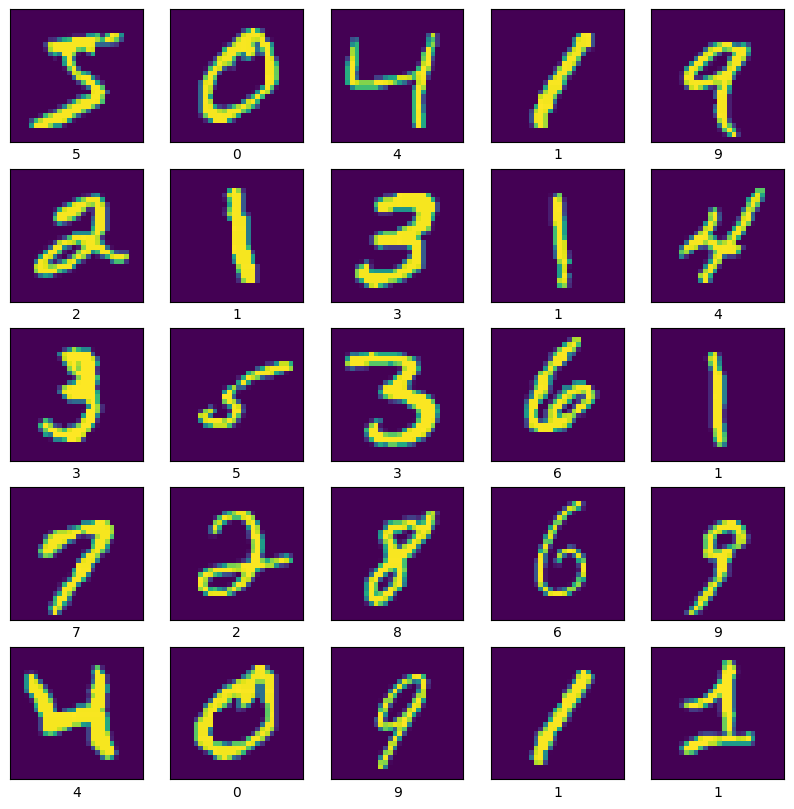

In [5]:
plt.figure(figsize=(10,10))
for fig_index in range(25):
    plt.subplot(5, 5, fig_index+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[fig_index])
    plt.xlabel(train_labels[fig_index])
plt.show()

# Design della CNN

Andiamo ora a creare una CNN come abbiamo fato nel primo esempio con il dataset CIFAR-10:
- **Feature Learning**: una successione di layer convoluzionali con attivazione ReLU seguiti da layer di pooling;
- **Classification**: una ANN per la classificazione, di tipo fully connected.

## Feature Learning

Anche in questo caso, ricorriamo a layer delle tipologie seguenti:
- [layers.Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D): crea un kernel convoluzionale;
- [layers.MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/): applica il downsampling in base alla tecnica di pooling indicata. 

Le immagini hanno dimensione $28\times 28$ e sono in bianco e nero, quindi l'input layer avrà una forma $28\times 28\times 1$, come già riportato sopra. Sfruttiamo di nuovo l'approccio con la classe [Sequential](https://keras.io/guides/sequential_model/) e inseriamo subito un [Rescaling layer](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/). Prima di questo, esplicitiamo la dimensione dell'input tramite un oggetto [Input](https://keras.io/api/layers/core_layers/input/) di Keras:

In [6]:
my_seed = 0
tf.keras.utils.set_random_seed(my_seed)

In [7]:
model = models.Sequential()
model.add(Input(shape=input_shape))
model.add(layers.Rescaling(scale=1./255))

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Per poter passare delle immagini a questa rete, dobbiamo aggiungere una terza dimensione al training e test set:

In [9]:
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)
print("Training image shape:", train_images.shape)
print("Test image shape:", test_images.shape)
print(train_images.shape[0], "train samples")
print(test_images.shape[0], "test samples")

Training image shape: (60000, 28, 28, 1)
Test image shape: (10000, 28, 28, 1)
60000 train samples
10000 test samples


Iniziamo con la creazione della parte convoluzionale. Per il momento, creiamo 3 layer convoluzionali, ognuno seguito da un layer di pooling con la seguente configurazione:
- **strides**: il passo del filtraggio da indicare su entrambi gli assi in una tuple, con valore (1, 1) di default;
- **padding**: il padding da applicare ai bordi, in cui il default è **valid**;
- **activation**: usiamo una attivazione ReLU;
- **filters**: indica la dimensione dell'output, ovvero il numero di filtri applicati;
- **kernel_size**: dimensione del filtro, passata come una tuple o lista di interi.

Due osservazioni importanti:
- per la dimensione dei filtri da applicare, solitamente conviene ricorrere a multipli di 2 per maggiore efficienza computazionale;
- l'output layer deve avere tanti neuroni quante sono le classi da predire.

In [10]:
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='valid'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='valid'))
model.add(layers.MaxPooling2D((2, 2)))

In questo caso, abbiamo inserito 32 filtri nel primo layer convoluzionale e 64 nel secondo, con due soli layer convoluzionali per iniziare. I kernel per il filtraggio sono sempre $3\times 3$. Per quanto riguarda il pooling ([qui](https://keras.io/api/layers/pooling_layers/) una lista delle possibilità di Keras), stiamo lavorando con il massimo tramite il layer [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/) (per quello basato sulla media, si ricorre al layer [AveragePooling2D](https://keras.io/api/layers/pooling_layers/average_pooling2d/)). Vediamo la rete ottenuta:

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,816 (73.50 KB)

 Trainable params: 18,816 (73.50 KB)

 Non-trainable params: 0 (0.00 B)

## Classification

Per la fully connected ANN di classificazione, inseriamo un layer [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) per convertire la matrice 3D in un array ad una dimensione; poi, inseriamo due layer di tipo [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense). Il secondo, che è il nostro output layer, deve avere tanti nodi quante sono le classi da predire: 10.

In [12]:
model.add(layers.Flatten())
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,816 (73.50 KB)

 Trainable params: 18,816 (73.50 KB)

 Non-trainable params: 0 (0.00 B)

Come possiamo notare, il flattening ci porta ad un array con 256 elementi (2x2x64). Completiamo la rete:

In [13]:
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(n_classes, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

Possiamo visualizzare il modello come già visto con le ANN:

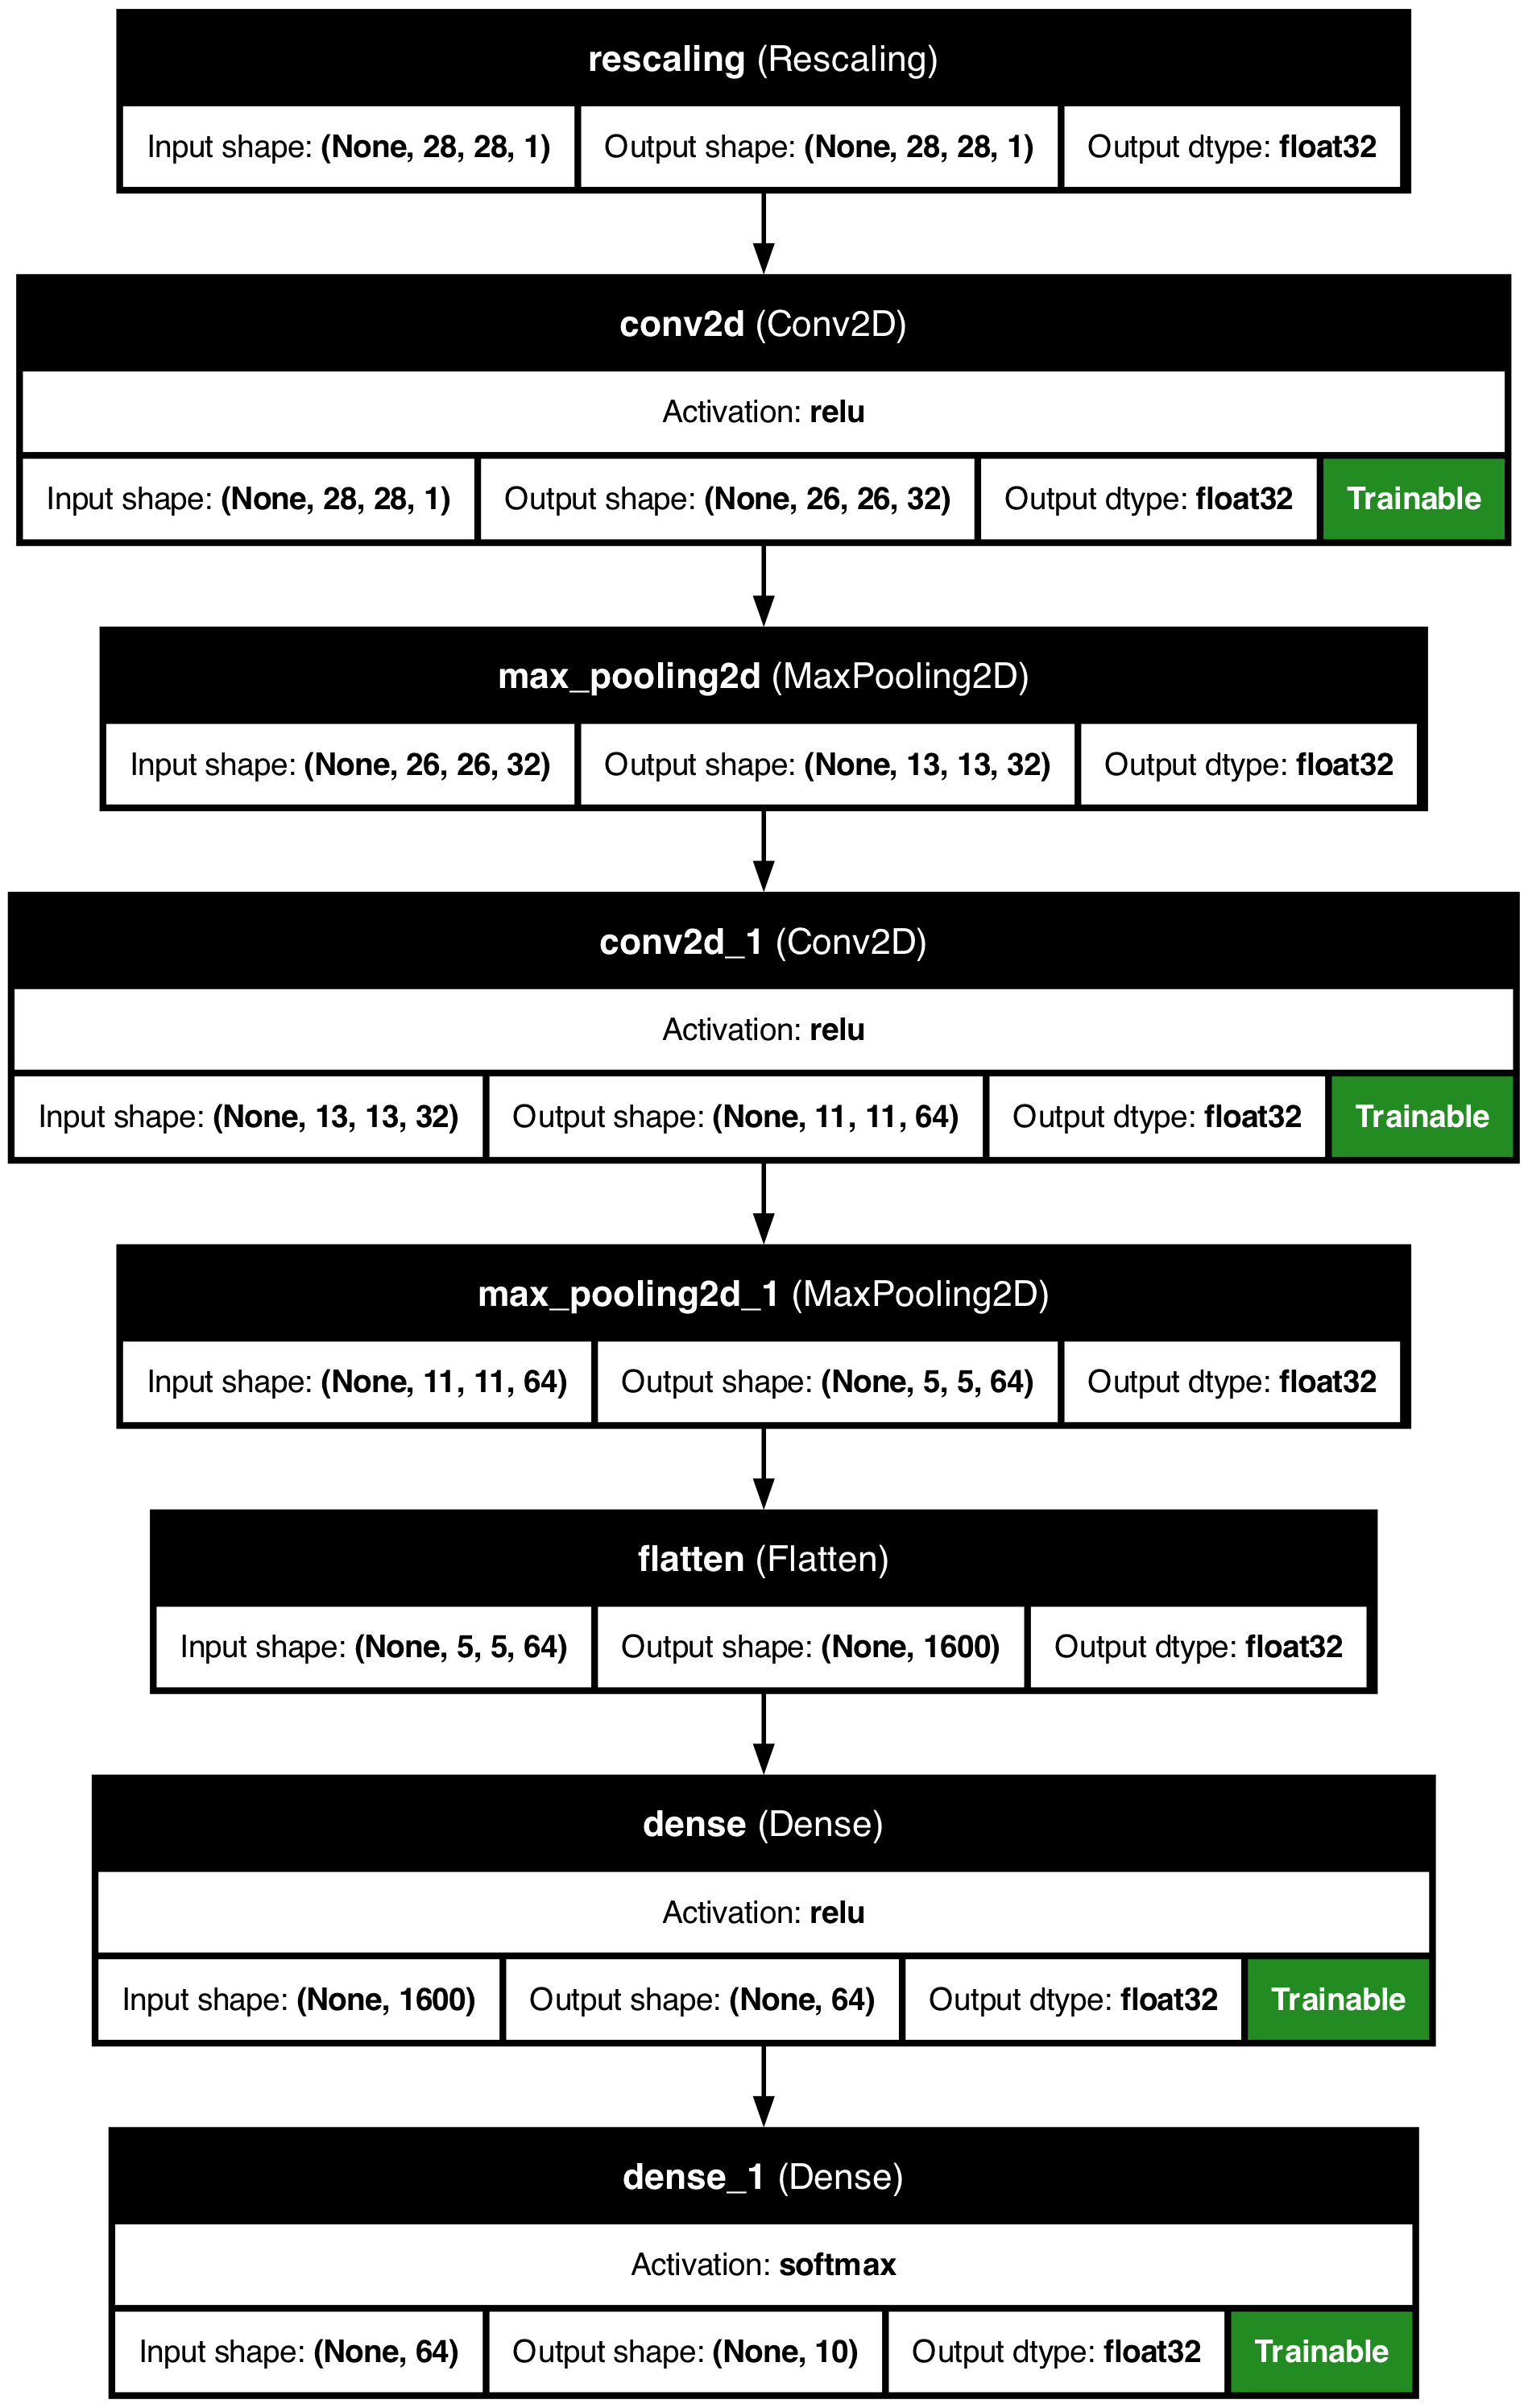

In [15]:
tf.keras.utils.plot_model(
    model,
    rankdir='TB',
    show_shapes=True,
    show_layer_names=True,
    show_dtype=True,
    show_layer_activations=True,
    show_trainable=True
)

## Addestramento e prestazioni

Possiamo ora addestrare la rete definendo la funzione di costo e l'ottimizzatore nel metodo compile(), come già fatto per le ANN, e poi chiamando il metodo fit() sul training set. Per quanto riguarda l'ottimizzazione:
- ricorriamo all'algoritmo Adam, una scelta sempre valida;
- come metrica, utilizziamo la **cross-entropy** (nota anche come log-loss, [link](https://www.datacamp.com/tutorial/the-cross-entropy-loss-function-in-machine-learning)): misura il numero medio di bit richiesti per identificare un evento da una distribuzione di probabilità $p$, ma ricorrendo ad uno schema/tecnica ottimizzata per una distribuzione di probabilità $q$. Viene utilizzata spesso in AI e ML per valutare le prestazioni di un modello quando l'obiettivo è la minimizzazione dell'errore tra la distribuzione di probabilità predetta e quella reale.

In Python, possiamo utilizzare un oggetto [SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy).

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
history = model.fit(
    train_images,
    train_labels,
    epochs=10, 
    validation_data=(test_images, test_labels)
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9100 - loss: 0.3030 - val_accuracy: 0.9834 - val_loss: 0.0586
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9845 - loss: 0.0500 - val_accuracy: 0.9882 - val_loss: 0.0364
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9901 - loss: 0.0326 - val_accuracy: 0.9873 - val_loss: 0.0382
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9930 - loss: 0.0222 - val_accuracy: 0.9884 - val_loss: 0.0388
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9947 - loss: 0.0159 - val_accuracy: 0.9874 - val_loss: 0.0406
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9959 - loss: 0.0123 - val_accuracy: 0.9884 - val_loss: 0.0457
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9961 - loss: 0.0116 - val_accuracy: 0.9887 - val_loss: 0.0441
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9974 - loss: 0

<Axes: >

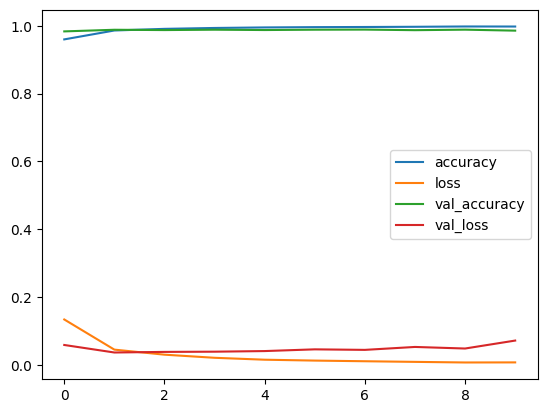

In [17]:
import pandas as pd
pd.DataFrame(history.history).plot()

Per valutare accuracy e loss sul test set, possiamo ricorrere al metodo [evaluate()](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate), che appunto fornisce queste due metriche in una tuple:

In [18]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print(test_acc)

0.9855999946594238


La rete si comporta a dir poco ottimamente! Per fare una predizione, prendiamo per comodità una delle immagini del test set e passiamola in ingresso:

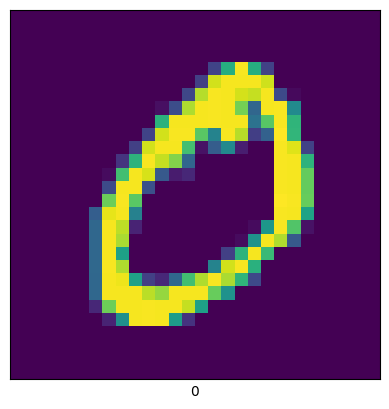

In [19]:
fig_index = 1
test_image = train_images[fig_index]
test_label = train_labels[fig_index]
plt.imshow(test_image)
plt.xlabel(test_label)
plt.xticks([])
plt.yticks([])
plt.show()

In [20]:
test_image.shape

(28, 28, 1)

Aggiungiamo sempre una dimensione per avere un tensore:

In [21]:
test_image = np.expand_dims(test_image, axis = 0)
test_image.shape

(1, 28, 28, 1)

Ora possiamo predire la label:

In [22]:
prediction = pd.DataFrame(model.predict(test_image, verbose=0))
prediction.T

0
0  1.000000e+00
1  6.552785e-23
2  6.147466e-15
3  3.884171e-17
4  8.736156e-20
5  3.153369e-16
6  2.641267e-14
7  1.236007e-18
8  9.392693e-17
9  1.285262e-12

Otteniamo le probabilità di appartenenza ad ogni classe: prendiamo quella con la probabilità maggiore:

In [23]:
print(f"Predizione: {np.argmax(prediction)}")

Predizione: 0


## Visualizzazione delle immagini filtrate

Andiamo anche in questo caso ad osservare le immagini filtrate, recuperando prima di tutto i nomi dei layer accedendo all'attributo **layers** del modello allenato: 

In [24]:
model.layers

[<Rescaling name=rescaling, built=True>,
 <Conv2D name=conv2d, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>]

Creiamo la "rete intermedia" che parte dall'input layer e ha come output layer il layer del quale vogliamo i risultati. Immaginiamo di essere interessati all'uscita del primo layer convoluzionale: 

In [25]:
intermediate_layer_model = models.Model(inputs=model.inputs, outputs=model.layers[1].output)
intermediate_layer_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320 (1.25 KB)

 Trainable params: 320 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

Prendiamo una figura di esempio da filtrare, come la seconda del training set (indice 1 di train_images):

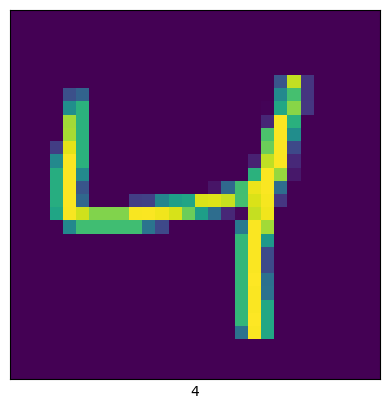

In [26]:
fig_index = 2
test_image = train_images[fig_index]
test_label = train_labels[fig_index]
plt.imshow(test_image)
plt.xlabel(test_label)
plt.xticks([])
plt.yticks([])
plt.show()

In [27]:
test_image.shape

(28, 28, 1)

Il contenuto di test_image è un array NumPy di dimensione $32\times 32\times 3$, ma dobbiamo stare attenti: l'input layer vuole in ingresso un array con 4 dimensioni in cui in realtà la prima è vuota. Per fare questo, possiamo aggiungere una dimensione all'array NumPy tramite il metodo [expand_dims](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html):

In [28]:
import numpy as np
test_image = np.expand_dims(test_image, axis = 0)
test_image.shape

(1, 28, 28, 1)

Ora possiamo effettuare la predizione su questo input, ma utilizzando il modello "intermedio":

In [29]:
result = intermediate_layer_model.predict(test_image, verbose=0)
result.shape

/Users/alessandroguidotti/opt/anaconda3/envs/work/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


(1, 26, 26, 32)

Possiamo notare come abbiamo ottenuto effettivamente 32 immagini filtrate di dimensione $30\times 30$. Andiamo a vedere il grafico:

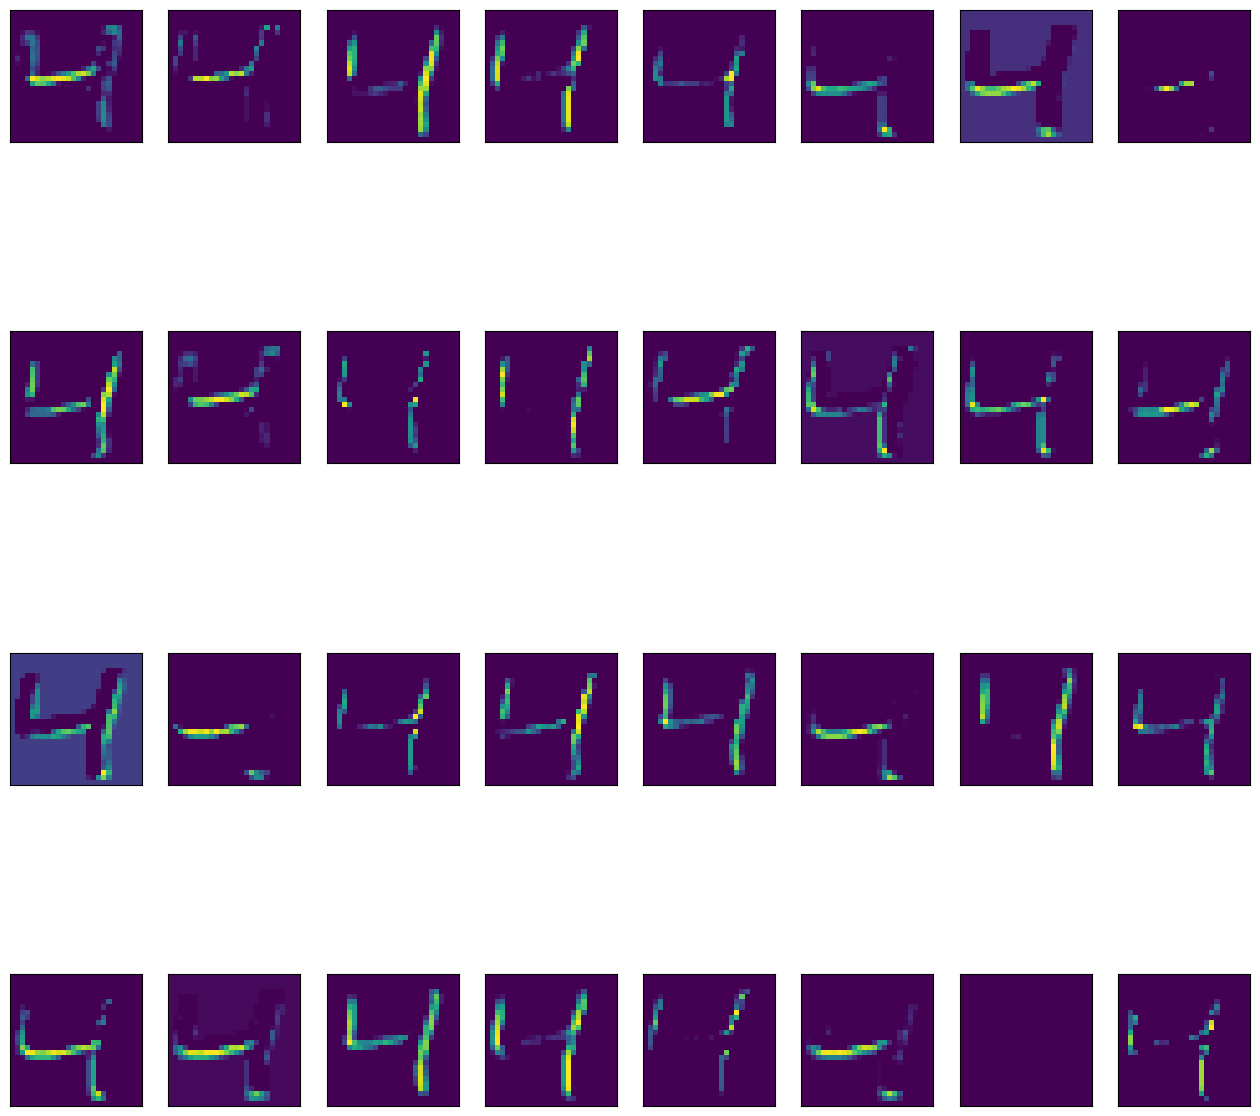

In [30]:
plt.figure(figsize=(16,16))
n_col = 8
n_row = 4
for filter_index in range(32):
    plt.subplot(n_row, n_col, filter_index+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(result[:, :, :, filter_index]))
plt.show()

## Visualizzazione dei filtri

Possiamo anche visualizzare i filtri utilizzati in uno specifico layer convoluzionale. Per farlo, recuperiamo appunto filtri e bias dal layer desiderato tramite il metodo [get_weights()](https://keras.io/api/layers/base_layer/):

In [31]:
filters, biases = model.layers[1].get_weights()

In [32]:
print(f"Filtri: {type(filters)}, shape: {filters.shape}")
print(f"Bias: {type(biases)}, shape: {biases.shape}")

Filtri: <class 'numpy.ndarray'>, shape: (3, 3, 1, 32)
Bias: <class 'numpy.ndarray'>, shape: (32,)


Normalizziamo i valori dei filtri per averli compresi tra 0 e 1, e mostrarli come gradazione di grigio:

In [33]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

E ora possiamo ottenere le immagini dei filtri. Per comodità, rappresentiamo solo quelli su uno dei canali, ad esempio il rosso (indice 0 della terza dimensione):

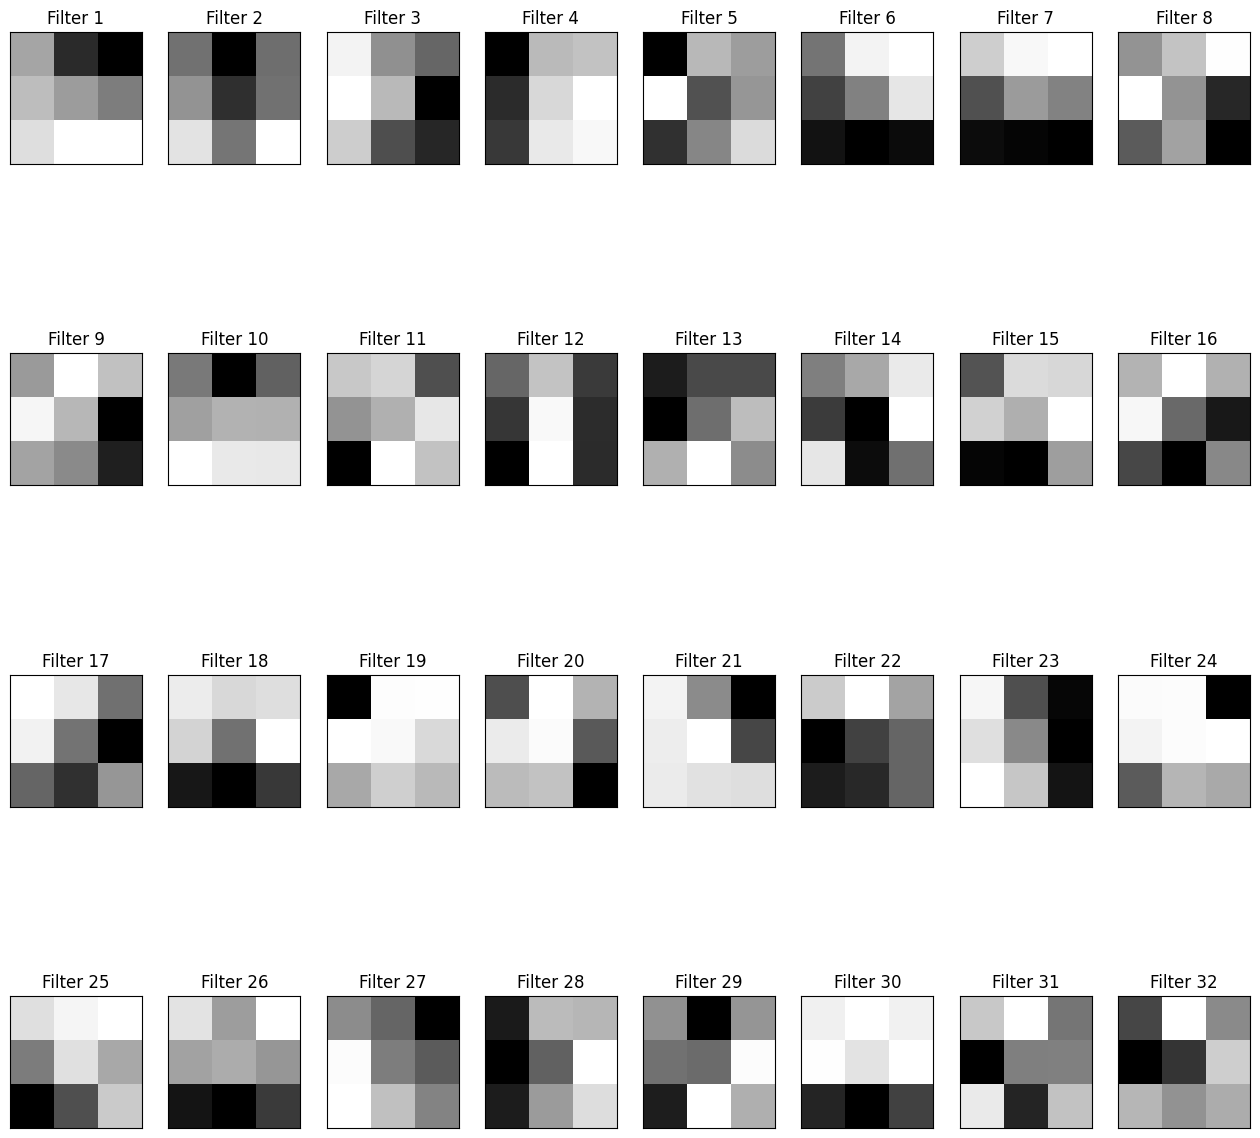

In [34]:
channel_index = 0
n_col = 8
n_row = 4
plt.figure(figsize=(16,16))
for filter_index in range(32):
    plt.subplot(n_row, n_col, filter_index+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(f"Filter {filter_index+1}")
    plt.imshow(np.squeeze(filters[:, :, channel_index, filter_index]), cmap='gray')
plt.show()